## **EEG ANALYSIS WITH MNE PYTHON** 

### Part 1

The following code is meant to serve as a guideline for ERP analysis, from importing data to topographic maps. The pipeline works for a single participant. To handle several participants go to part 2. 

Python 3.6, MNE 0.14

Lorenzo Alfine, May 2017

#### STEPS:

* Importing packages
* Set directories and load data
* Preprocessing
  * low-pass filter
  * high-pass filter
* Creating epochs
* Artifact rejection
  * autoreject tool
  * ICA
* Referencing
* Creating evoked objects
* Calculating GFP
* Plots
  * GFPs
  * Topographic maps


`%matplotlib` is used for interactive plots

In [2]:
%matplotlib qt5

#### Importing all the packages

Link to MNE package: https://www.martinos.org/mne/stable/index.html , all the MNE functions, their arguments and outputs, used in this notebook can be found here. The site also contains helpful tutorials and exemples.

Linik to autoreject tool: http://autoreject.github.io/

In [3]:

import os
import mne
from matplotlib import pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
from autoreject import LocalAutoRejectCV, plot_epochs
import pandas as pd
from scipy import signal

C:\Users\alfine-l\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


#### Setting directories, load montage (distribution of electrodes) and data (brainvision format)

In [4]:
# Setting the directory where to save the data (intermediate and final results)

base_dir = os.path.normpath('L:/PSY-Studenten/Lorenzo/Python Scripts/eeg_test_mne')
data_dir = os.path.join(base_dir, 'Data')

#MONTAGE, load the montage with the positions and configuration of all the 64 electrodes
montage = mne.channels.read_montage(kind='standard-10-5-cap385', path='L:/PSY-Studenten/Lorenzo/22_TaPa2/Montages')

# LOAD DATA
# path to the 3 blocks of data of the participant
file_name1 = 'L:/PSY-Studenten/Lorenzo/Python Scripts/EEG_analysis/22_TaPa2/EEG/TaPa2_01.vhdr'
file_name2 = 'L:/PSY-Studenten/Lorenzo/Python Scripts/EEG_analysis/22_TaPa2/EEG/TaPa2_02.vhdr'
file_name3 = 'L:/PSY-Studenten/Lorenzo/Python Scripts/EEG_analysis/22_TaPa2/EEG/TaPa2_03.vhdr'

In [5]:
# READ DATA

raw1 = mne.io.read_raw_brainvision(file_name1, preload=True)
raw2 = mne.io.read_raw_brainvision(file_name2, preload=True)
raw3 = mne.io.read_raw_brainvision(file_name3, preload=True)

# in this case, recordings are divided in 3 blocks, _01 _02, _03. They are in brainvsion format.

Extracting parameters from L:/PSY-Studenten/Lorenzo/Python Scripts/EEG_analysis/22_TaPa2/EEG/TaPa2_01.vhdr...
Setting channel info structure...
Reading 0 ... 446124  =      0.000 ...   892.248 secs...
Extracting parameters from L:/PSY-Studenten/Lorenzo/Python Scripts/EEG_analysis/22_TaPa2/EEG/TaPa2_02.vhdr...
Setting channel info structure...
Reading 0 ... 448874  =      0.000 ...   897.748 secs...
Extracting parameters from L:/PSY-Studenten/Lorenzo/Python Scripts/EEG_analysis/22_TaPa2/EEG/TaPa2_03.vhdr...
Setting channel info structure...
Reading 0 ... 443949  =      0.000 ...   887.898 secs...


### ANALYSIS

In [6]:
# find the EVENTS (fixation cross, taste stimuli,...) in every block
events1 = mne.find_events(raw1)
events2 = mne.find_events(raw2)
events3 = mne.find_events(raw3)

# shift the events in time by 36 ms. This is due to the gustometer delay between digital onset of the stimulus and
# acutual deliver of it on the tongue
events1_shift = mne.event.shift_time_events(events1, [140,150,160,170], 0.036, raw1.info['sfreq'])
events2_shift = mne.event.shift_time_events(events2, [140,150,160,170], 0.036, raw1.info['sfreq'])
events3_shift = mne.event.shift_time_events(events3, [140,150,160,170], 0.036, raw1.info['sfreq'])

# set the MONTAGE on the raw data
raw1.set_montage(montage)
raw2.set_montage(montage)
raw3.set_montage(montage)


359 events found
Events id: [  4   6  10  12  15  16  17  18  19  20  22  24  25  28  29  30  31  32
  33  35  38  39  43  48  49  50  51  52  53  55  58  59  61  62  64  65
  67  69  71  72  73  74  75  76  77  80  83  85  88  95 110 140 150 160
 170 190 191 192 193 194 197 198 199 200 201 210 211]
360 events found
Events id: [  4   5  11  13  14  15  17  20  22  23  27  28  29  30  35  36  37  40
  41  43  45  46  48  49  50  51  52  54  55  57  58  59  60  61  66  68
  69  70  71  73  74  75  76  77  78  79  80  89  90 110 140 150 160 170
 190 191 192 193 194 197 198 200 201 210]
360 events found
Events id: [  2   3   8  12  13  14  15  16  21  22  24  27  28  29  30  31  32  34
  36  37  38  44  46  47  49  50  51  52  53  55  57  60  61  62  63  65
  66  68  71  73  74  75  79  80  81  82  86  87  88  90  93  94  98  99
 110 140 150 160 170 190 191 192 193 194 197 198 200 201]


<RawBrainVision  |  TaPa2_03.eeg, n_channels x n_times : 64 x 443950 (887.9 sec), ~216.9 MB, data loaded>

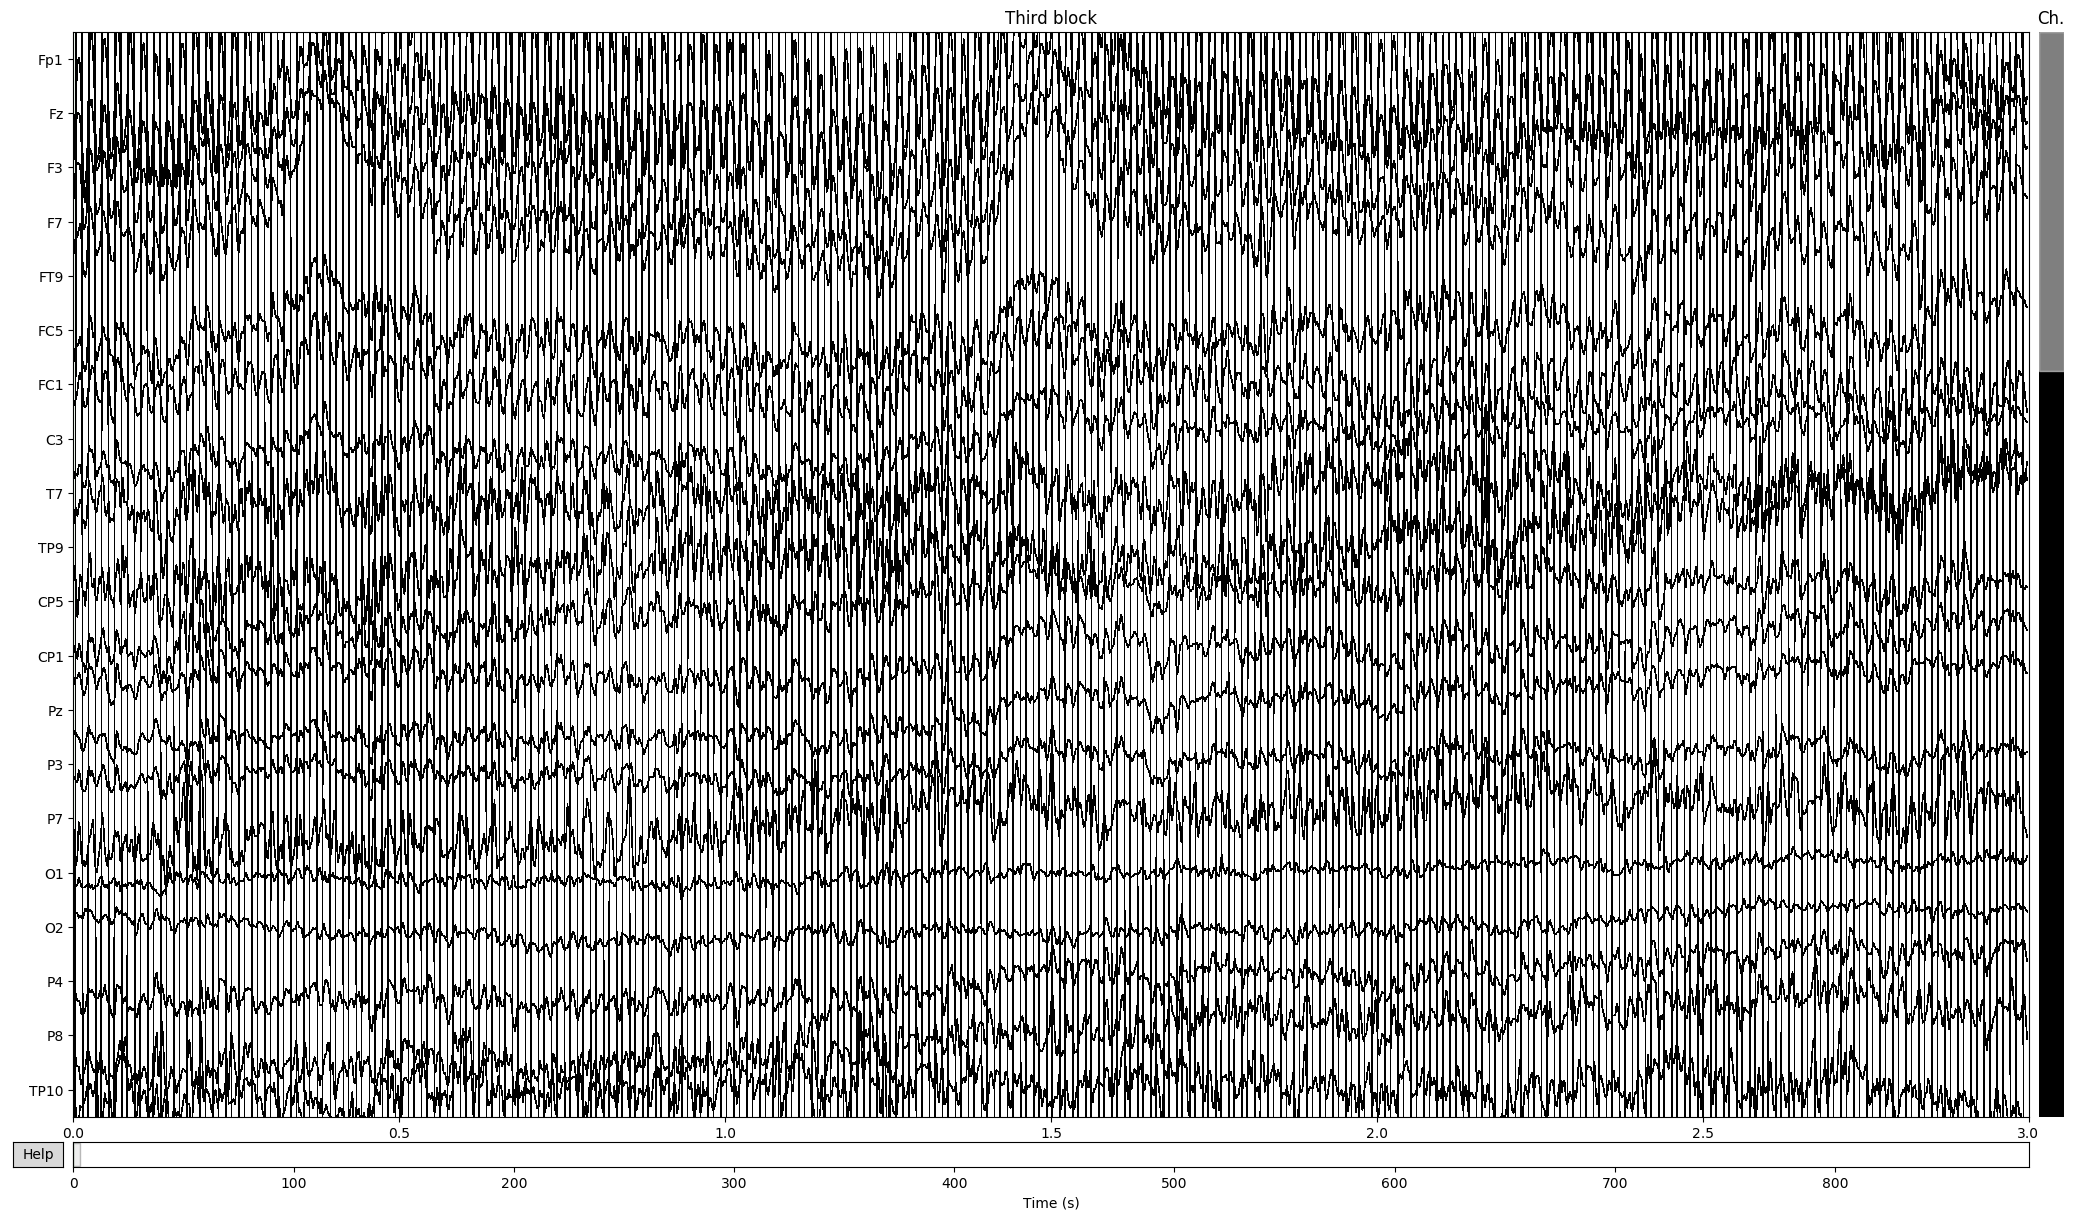

In [7]:
# VISUALIZE RAW DATA
# is possible to exclude a noisy channel simply by clicking on it in the interactive plot

raw1.plot(duration= 3, title='First block')
raw2.plot(duration= 3, title='Second block')
raw3.plot(duration= 3, title='Third block')

In [9]:
# .info is particularly useful to have information regarding raw and epoch objects.

raw1.info

<Info | 16 non-empty fields
    bads : 'list | 0 items
    buffer_size_sec : 'float | 1.0
    ch_names : 'list | Fp1, Fz, F3, F7, FT9, FC5, FC1, C3, T7, ...
    chs : 'list | 64 items (EEG: 63, STIM: 1)
    comps : 'list | 0 items
    custom_ref_applied : 'bool | False
    dev_head_t : 'mne.transforms.Transform | 3 items
    events : 'list | 0 items
    highpass : 'float | 0.0 Hz
    hpi_meas : 'list | 0 items
    hpi_results : 'list | 0 items
    lowpass : 'float | 250.0 Hz
    meas_date : 'int | 1494238284
    nchan : 'int | 64
    projs : 'list | 0 items
    sfreq : 'float | 500.0 Hz
    acq_pars : 'NoneType
    acq_stim : 'NoneType
    ctf_head_t : 'NoneType
    description : 'NoneType
    dev_ctf_t : 'NoneType
    dig : 'NoneType
    experimenter : 'NoneType
    file_id : 'NoneType
    hpi_subsystem : 'NoneType
    kit_system_id : 'NoneType
    line_freq : 'NoneType
    meas_id : 'NoneType
    proj_id : 'NoneType
    proj_name : 'NoneType
    subject_info : 'NoneType
    xplotter_

#### Preprocessing: filtering low-pass and high-pass

In [12]:
# data need to be preloaded
raw1.load_data()
raw2.load_data()
raw3.load_data()

# apply low-pass filter: 30 Hz, .copy() is used so raw1,2,3 are not modified in place
raw1_filtered_lp = raw1.copy().filter(None, 30, h_trans_bandwidth='auto', filter_length='auto', phase='zero')
raw2_filtered_lp = raw2.copy().filter(None, 30, h_trans_bandwidth='auto', filter_length='auto', phase='zero')
raw3_filtered_lp = raw3.copy().filter(None, 30, h_trans_bandwidth='auto', filter_length='auto', phase='zero')

# apply high-pass filter: 0.5 Hz 
raw1_filtered = raw1_filtered_lp.copy().filter(.5, None, l_trans_bandwidth='auto', filter_length='auto', phase='zero') 
raw2_filtered = raw2_filtered_lp.copy().filter(.5, None, l_trans_bandwidth='auto', filter_length='auto', phase='zero') 
raw3_filtered = raw3_filtered_lp.copy().filter(.5, None, l_trans_bandwidth='auto', filter_length='auto', phase='zero')

Setting up low-pass filter at 30 Hz
h_trans_bandwidth chosen to be 7.5 Hz
Filter length of 440 samples (0.880 sec) selected
Setting up low-pass filter at 30 Hz
h_trans_bandwidth chosen to be 7.5 Hz
Filter length of 440 samples (0.880 sec) selected
Setting up low-pass filter at 30 Hz
h_trans_bandwidth chosen to be 7.5 Hz
Filter length of 440 samples (0.880 sec) selected
Setting up high-pass filter at 0.5 Hz
l_trans_bandwidth chosen to be 0.5 Hz
Filter length of 6600 samples (13.200 sec) selected
Setting up high-pass filter at 0.5 Hz
l_trans_bandwidth chosen to be 0.5 Hz
Filter length of 6600 samples (13.200 sec) selected
Setting up high-pass filter at 0.5 Hz
l_trans_bandwidth chosen to be 0.5 Hz
Filter length of 6600 samples (13.200 sec) selected


In [13]:
# SAVE FILTERED DATA

raw1_filtered.save(fname=os.path.join(data_dir, 'raw1_filtered_raw.fif'),overwrite=True)
raw2_filtered.save(fname=os.path.join(data_dir, 'raw2_filtered_raw.fif'),overwrite=True)
raw3_filtered.save(fname=os.path.join(data_dir, 'raw3_filtered_raw.fif'),overwrite=True)

Overwriting existing file.
Writing C:\Users\Lorenzo\Documents\Python Scripts\eeg_test_mne\Data\raw1_filtered_raw.fif
Closing C:\Users\Lorenzo\Documents\Python Scripts\eeg_test_mne\Data\raw1_filtered_raw.fif [done]
Overwriting existing file.
Writing C:\Users\Lorenzo\Documents\Python Scripts\eeg_test_mne\Data\raw2_filtered_raw.fif
Closing C:\Users\Lorenzo\Documents\Python Scripts\eeg_test_mne\Data\raw2_filtered_raw.fif [done]
Overwriting existing file.
Writing C:\Users\Lorenzo\Documents\Python Scripts\eeg_test_mne\Data\raw3_filtered_raw.fif
Closing C:\Users\Lorenzo\Documents\Python Scripts\eeg_test_mne\Data\raw3_filtered_raw.fif [done]


In [ ]:
# LOAD FILTERED DATA

raw1_filtered = mne.io.fiff.read_raw_fif(fname=os.path.join(data_dir, 'raw1_filtered_raw.fif'))
raw2_filtered = mne.io.fiff.read_raw_fif(fname=os.path.join(data_dir, 'raw2_filtered_raw.fif'))
raw3_filtered = mne.io.fiff.read_raw_fif(fname=os.path.join(data_dir, 'raw3_filtered_raw.fif'))

#### Creating EPOCHS from filtered signals, merge them togheter

In [14]:
# EPOCHING

ids = [140,150,160,170] # these are the ids associated with the onset of the four tastants: 140-salty, 150-sweet, 160-sour, 170-bitter

# create an epoch object: here every epoch lasts 2500 ms, 500 ms pre-stimulus, 2000 ms post-stimulus
epochs1 = mne.Epochs(raw1_filtered, events1, event_id=ids, tmin=-0.5, tmax=2,
                     baseline=None,preload=True, add_eeg_ref=False, detrend=1)
epochs2 = mne.Epochs(raw2_filtered, events2, event_id=ids, tmin=-0.5, tmax=2,
                     baseline=None,preload=True, add_eeg_ref=False, detrend=1)
epochs3 = mne.Epochs(raw3_filtered, events3, event_id=ids, tmin=-0.5, tmax=2,
                     baseline=None,preload=True, add_eeg_ref=False, detrend=1)

# merge the epochs of the 3 blocks in a single object
epochs_merged = mne.concatenate_epochs([epochs1, epochs2, epochs3])

40 matching events found
0 projection items activated
Loading data for 40 events and 1251 original time points ...
0 bad epochs dropped
40 matching events found
0 projection items activated
Loading data for 40 events and 1251 original time points ...
0 bad epochs dropped
40 matching events found
0 projection items activated
Loading data for 40 events and 1251 original time points ...
0 bad epochs dropped
120 matching events found
0 bad epochs dropped


In [15]:
# SAVE EPOCHS DATA

epochs_merged.save(fname=os.path.join(data_dir, 'epochs_merged-epo.fif'))

In [ ]:
# LOAD EPOCHS DATA

epochs_merged = mne.read_epochs(fname=os.path.join(data_dir, 'epochs_merged-epo.fif'))

### ARTIFACTS REJECTION

#### 1) Autoreject

In [16]:
# AUTOREJECT, this tool automatically repairs or rejects bad trials. Is based on machine learning. It can take some minutes.

consense = np.arange(.5,.9,.05)
n_interp = [16,32,48]

n = len(epochs_merged.events)
ar = LocalAutoRejectCV(consensus_percs=np.asarray(consense), n_interpolates=np.asarray(n_interp))

#epochs_clean is the epoch object after the repair/rejection of bad trials
epochs_clean = ar.fit_transform(epochs_merged.pick_types(eeg=True, meg=False))

print ('Removed {0} epochs.'.format(n-len(epochs_clean.events)))

[.............                           ] 33.33333 | n_interp   ochs   s   hs   Estimated consensus_perc=0.70 and n_interpolate=32
[                                        ] 0.83333 | Repairing epochs   Removed 0 epochs.


In [17]:
# SAVE EPOCHS AFTER AUTOREJECT

epochs_clean.save(fname=os.path.join(data_dir, 'epochs_clean-epo.fif'))

In [10]:
# LOAD EPOCHS DATA AFTER AUTOREJECT

epochs_clean = mne.read_epochs(fname=os.path.join(data_dir, 'epochs_clean-epo.fif'))

Reading L:\PSY-Studenten\Lorenzo\Python Scripts\eeg_test_mne\Data\epochs_clean-epo.fif ...
Isotrak not found
    Found the data of interest:
        t =    -500.00 ...    2000.00 ms (None)
        0 CTF compensation matrices available
114 matching events found
114 matching events found
0 projection items activated


#### 2) ICA (Independent component analysis)

Is possible to kick out a ICA component by clicking on it in the plot. Also, additional information about a component are available by clicking on the "topographic" map of a component.

Fitting ICA to data using 63 channels. 
Please be patient, this may take some time
Inferring max_pca_components from picks.
Using all PCA components: 63
<ICA  |  epochs decomposition, fit (fastica): 142614 samples, 63 components, channels used: "eeg">


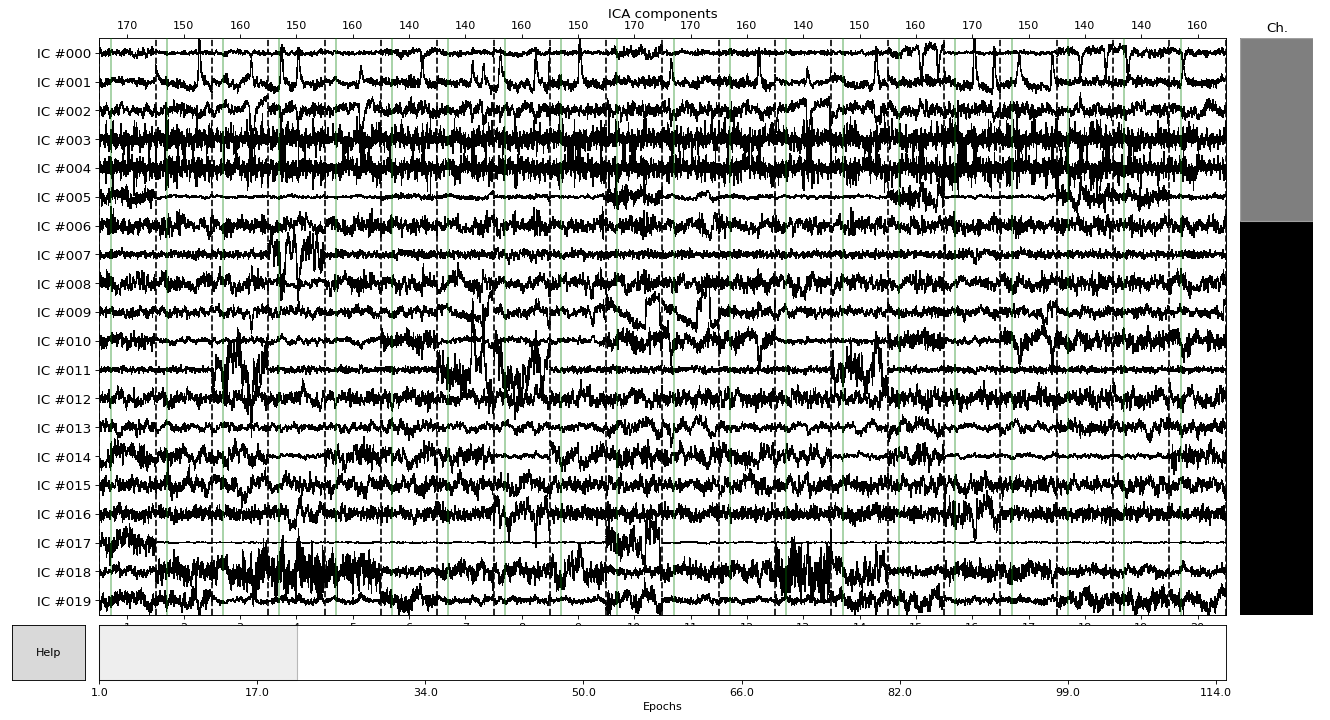

In [11]:
# ICA, independent component analysis

n_components = 63 #if  whitin 0-1, explained by variance, otherwise define number of components
method = 'fastica'
random_state = 5

#ICA ON EPOCHS
# n_components=None -> all PCA components are used
ica = mne.preprocessing.ICA(n_components=None, method=method, random_state=random_state)
ica.fit(epochs_clean)
print(ica)

ica.plot_components(cmap='interactive', inst=epochs_clean)
ica.plot_sources(epochs_clean)

Transforming to ICA space (63 components)
Zeroing out 0 ICA components


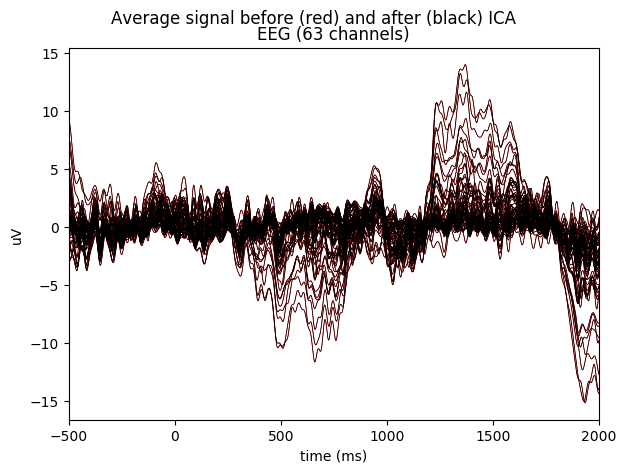

In [12]:
# visualize the result when zeroing some ICA components. Average plot (evoked object)

ica.plot_overlay(epochs_clean.average())

In [24]:
# Apply the ICA result on epochs_clean and save the result in epochs_final

ica.apply(epochs_clean)
epochs_final = epochs_clean.copy()

In [ ]:
# SAVE EPOCHS AFTER ICA, SAVE ICA OBJECT

ica.save(fname=os.path.join(data_dir, 'ica-ica.fif'))
epochs_final.save(fname=os.path.join(data_dir, 'epochs_final-epo.fif'))

In [8]:
# LOAD EPOCHS DATA AND ICA OBJECT AFTER ICA

ica = mne.preprocessing.read_ica(fname=os.path.join(data_dir,'ica-ica.fif'))
epochs_final = mne.read_epochs(fname=os.path.join(data_dir, 'epochs_final-epo.fif'))

Reading L:\PSY-Studenten\Lorenzo\Python Scripts\eeg_test_mne\Data\ica-ica.fif ...
Isotrak not found
Now restoring ICA solution ...
Ready.
Reading L:\PSY-Studenten\Lorenzo\Python Scripts\eeg_test_mne\Data\epochs_final-epo.fif ...
Isotrak not found
    Read a total of 1 projection items:
        Average EEG reference (1 x 64) active
    Found the data of interest:
        t =    -500.00 ...    2000.00 ms (None)
        0 CTF compensation matrices available
118 matching events found
Created an SSP operator (subspace dimension = 1)
118 matching events found
Created an SSP operator (subspace dimension = 1)
1 projection items activated


#### Reference

In the case of this subject, electrode Oz was used as a reference during recording. So was necessary to manually add the channel after the analysis and reapply the montage.

In [9]:
# ADD REFERENCE CHANNEL Oz. If Oz is used as a reference, it is not present in the 64 channels.

mne.add_reference_channels(epochs_final, 'Oz', copy=False) #data preload needed
epochs_final.set_montage(montage=montage) #after adding Oz,apply montage again

ValueError: Channel Oz already specified in inst.

In [10]:
# APPLY AVERAGE REFERENCE and BASELINE

epochs_final.info['custom_ref_applied'] = False
epochs_final.set_eeg_reference(ref_channels=None) #setting average reference

epochs_final.apply_proj() #this applies the reference on the data

# apply BASELINE, from -200 ms to 0 ms
epochs_final.apply_baseline(baseline=(-0.2,0))


An average reference projection was already added. The data has been left untouched.
Projections have already been applied. Setting proj attribute to True.
Applying baseline correction (mode: mean)


<ipython-input-10-f8a1e4e74dd3>:3: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  epochs_final.set_eeg_reference(ref_channels=None) #setting average reference


<EpochsFIF  |  n_events : 118 (all good), tmin : -0.5 (s), tmax : 2.0 (s), baseline : (-0.2, 0), ~72.2 MB, data loaded,
 '140': 29, '150': 30, '160': 30, '170': 29>

#### Creating EVOKED objects

In [11]:
# Divide EPOCHS in 4 subsets, one per tastant. Then calculate the evoked object with .average()

epochs_salty = epochs_final['140']
evoked_salty = epochs_salty.average()

#sweet
epochs_sweet = epochs_final['150']
evoked_sweet = epochs_sweet.average()

#sour
epochs_sour = epochs_final['160']
evoked_sour = epochs_sour.average()

#bitter
epochs_bitter = epochs_final['170']
evoked_bitter = epochs_bitter.average()

In [ ]:
# SAVE EVOKED OBJECTS

evoked_salty.save(fname=os.path.join(data_dir, 'patient_evoked_salty-ave.fif'))
evoked_sweet.save(fname=os.path.join(data_dir, 'patient_evoked_sweet-ave.fif'))
evoked_sour.save(fname=os.path.join(data_dir, 'patient_evoked_sour-ave.fif'))
evoked_bitter.save(fname=os.path.join(data_dir, 'patient_evoked_bitter-ave.fif'))

In [24]:
# LOAD EVOKED 

evoked_salty = mne.read_evokeds(fname=os.path.join(data_dir, 'patient_evoked_salty-ave.fif'), condition=0)
evoked_sweet = mne.read_evokeds(fname=os.path.join(data_dir, 'patient_evoked_sweet-ave.fif'), condition=0)
evoked_sour = mne.read_evokeds(fname=os.path.join(data_dir, 'patient_evoked_sour-ave.fif'), condition=0)
evoked_bitter = mne.read_evokeds(fname=os.path.join(data_dir, 'patient_evoked_bitter-ave.fif'), condition=0)

Reading L:\PSY-Studenten\Lorenzo\Python Scripts\eeg_test_mne\Data\patient_evoked_salty-ave.fif ...
Isotrak not found
    Read a total of 1 projection items:
        Average EEG reference (1 x 64) active
    Found the data of interest:
        t =    -500.00 ...    2000.00 ms (140)
        0 CTF compensation matrices available
        nave = 29 - aspect type = 100
Projections have already been applied. Setting proj attribute to True.
No baseline correction applied
Reading L:\PSY-Studenten\Lorenzo\Python Scripts\eeg_test_mne\Data\patient_evoked_sweet-ave.fif ...
Isotrak not found
    Read a total of 1 projection items:
        Average EEG reference (1 x 64) active
    Found the data of interest:
        t =    -500.00 ...    2000.00 ms (150)
        0 CTF compensation matrices available
        nave = 30 - aspect type = 100
Projections have already been applied. Setting proj attribute to True.
No baseline correction applied
Reading L:\PSY-Studenten\Lorenzo\Python Scripts\eeg_test_mne\Dat

#### Calculating GFP (Global Field Power)

Current version of mne (0.14) doesn't have a GFP object. Thus GFP is manually calculated from `evoked_salty.data`

In [ ]:
#GFP

salty_gfp = pd.DataFrame(
   [np.std(evoked_salty.data, ddof=0, axis=0)]).mean(axis='rows')
sweet_gfp = pd.DataFrame(
   [np.std(evoked_sweet.data, ddof=0, axis=0)]).mean(axis='rows')
sour_gfp = pd.DataFrame(
   [np.std(evoked_sour.data, ddof=0, axis=0)]).mean(axis='rows')
bitter_gfp = pd.DataFrame(
   [np.std(evoked_bitter.data, ddof=0, axis=0)]).mean(axis='rows')
pd.DataFrame([salty_gfp, sweet_gfp, sour_gfp,
              bitter_gfp]).T.plot()

In [14]:
# LOW-PASS FILTER GFP SIGNALS

b,a = signal.butter(4, 0.020)
time = evoked_bitter.times*1000

salty_filtered = signal.filtfilt(b,a,salty_gfp)
sweet_filtered = signal.filtfilt(b,a,sweet_gfp)
sour_filtered = signal.filtfilt(b,a,sour_gfp)
bitter_filtered = signal.filtfilt(b,a,bitter_gfp)

In [ ]:
# SAVE GFP numpy.ndarray data

np.save(os.path.join(data_dir, 'gfp_salty_patient.npy'),salty_filtered)
np.save(os.path.join(data_dir, 'gfp_sweet_patient.npy'),sweet_filtered)
np.save(os.path.join(data_dir, 'gfp_sour_patient.npy'),sour_filtered)
np.save(os.path.join(data_dir, 'gfp_bitter_patient.npy'),bitter_filtered)

In [13]:
# LOAD SAVED GFPs

salty_filtered = np.load(os.path.join(data_dir, 'gfp_salty_patient.npy'))
sweet_filtered = np.load(os.path.join(data_dir, 'gfp_sweet_patient.npy'))
sour_filtered = np.load(os.path.join(data_dir, 'gfp_sour_patient.npy'))
bitter_filtered = np.load(os.path.join(data_dir, 'gfp_bitter_patient.npy'))

### PLOTS

#### GFPs of the four tastants

In [26]:
# PLOT GFPs on the same figure

#plt.close('all')
fig = plt.figure()                                                               
ax = fig.add_subplot(1,1,1)  
plt.plot(time, salty_filtered, label='salty filtered', lw=2)
plt.plot(time, sweet_filtered, label= 'sweet filtered', lw=2)
plt.plot(time, sour_filtered, label= 'sour filtered', lw=2)
plt.plot(time, bitter_filtered, label= 'bitter filtered', lw=2)
minor_ticks = np.arange(-500,2000, 250)

ax.set_xticks(minor_ticks, minor=True)
ax.grid(which='both')

scale = 1e6
ticks = ticker.FuncFormatter(lambda y, pos: '{0:g}'.format(y*scale))
ax.yaxis.set_major_formatter(ticks)

plt.xlabel('time [ms]')
plt.ylabel(r'amplitude [ $\mu$ V]')
plt.legend()
plt.show()

#### Topographic maps, one per tastant

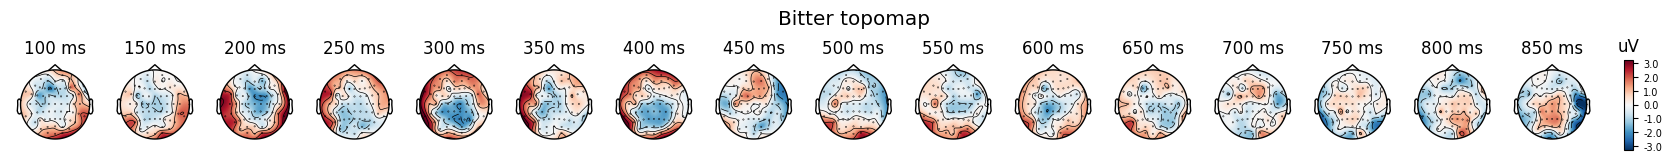

In [22]:
# PLOT TOPOGRAPHIC MAPS

interval = np.arange(0.1, 0.9, 0.05)

evoked_salty.plot_topomap(times=interval, title='Salty topomap', average=0.025)
evoked_sweet.plot_topomap(times=interval, title='Sweet topomap', average=0.025)
evoked_sour.plot_topomap(times=interval, title='Sour topomap', average=0.025)
evoked_bitter.plot_topomap(times=interval, title='Bitter topomap', average=0.025)